# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test']#[:9900, :]
test_y = mat_data_test['Y_test']#[:9900, :]

# validation_x = mat_data_test['X_test'][9900:, :]
# validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
# print("Validation data shape: " + str(validation_x.shape))
# print("Validation label shape: " + str(validation_y.shape))
print(np.max(test_x), np.min(test_x))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (10000, 112, 112)
Test label shape: (10000, 10)
1.0 0.0


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/mod_soft/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

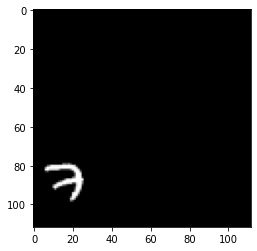

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape: 112x112


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [14]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
            #validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            #val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "soft_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/55000 / Cost: 0.71213335 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 256/55000 / Cost: 0.6612546 / Training Accuracy: 0.125
Epoch: 1 / Batch: 512/55000 / Cost: 0.6065653 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 768/55000 / Cost: 0.5390297 / Training Accuracy: 0.07421875
Epoch: 1 / Batch: 1024/55000 / Cost: 0.45566854 / Training Accuracy: 0.1328125
Epoch: 1 / Batch: 1280/55000 / Cost: 0.38391572 / Training Accuracy: 0.125
Epoch: 1 / Batch: 1536/55000 / Cost: 0.34096545 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 1792/55000 / Cost: 0.32913524 / Training Accuracy: 0.08203125
Epoch: 1 / Batch: 2048/55000 / Cost: 0.33522585 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 2304/55000 / Cost: 0.35171655 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 2560/55000 / Cost: 0.35449594 / Training Accuracy: 0.1171875
Epoch: 1 / Batch: 2816/55000 / Cost: 0.3550562 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 3072/55000 / Cost: 0.3503665 / Training Accuracy: 

Epoch: 1 / Batch: 26624/55000 / Cost: 0.32434335 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 26880/55000 / Cost: 0.3256533 / Training Accuracy: 0.078125
Epoch: 1 / Batch: 27136/55000 / Cost: 0.32494336 / Training Accuracy: 0.0859375
Epoch: 1 / Batch: 27392/55000 / Cost: 0.32381362 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 27648/55000 / Cost: 0.32675105 / Training Accuracy: 0.0703125
Epoch: 1 / Batch: 27904/55000 / Cost: 0.32690617 / Training Accuracy: 0.12109375
Epoch: 1 / Batch: 28160/55000 / Cost: 0.32606903 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 28416/55000 / Cost: 0.3267849 / Training Accuracy: 0.078125
Epoch: 1 / Batch: 28672/55000 / Cost: 0.32555866 / Training Accuracy: 0.07421875
Epoch: 1 / Batch: 28928/55000 / Cost: 0.32417533 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 29184/55000 / Cost: 0.32455444 / Training Accuracy: 0.12890625
Epoch: 1 / Batch: 29440/55000 / Cost: 0.3241896 / Training Accuracy: 0.12890625
Epoch: 1 / Batch: 29696/55000 / Cost: 0.3267

Epoch: 1 / Batch: 52992/55000 / Cost: 0.30579624 / Training Accuracy: 0.22265625
Epoch: 1 / Batch: 53248/55000 / Cost: 0.30626994 / Training Accuracy: 0.21875
Epoch: 1 / Batch: 53504/55000 / Cost: 0.30730376 / Training Accuracy: 0.203125
Epoch: 1 / Batch: 53760/55000 / Cost: 0.3062605 / Training Accuracy: 0.22265625
Epoch: 1 / Batch: 54016/55000 / Cost: 0.30375087 / Training Accuracy: 0.22265625
Epoch: 1 / Batch: 54272/55000 / Cost: 0.31084245 / Training Accuracy: 0.16796875
Epoch: 1 / Batch: 54528/55000 / Cost: 0.3084886 / Training Accuracy: 0.203125
Epoch: 1 / Batch: 54784/55000 / Cost: 0.30361965 / Training Accuracy: 0.22222222
Epoch: 2 / Batch: 0/55000 / Cost: 0.30012316 / Training Accuracy: 0.2421875
Epoch: 2 / Batch: 256/55000 / Cost: 0.30237412 / Training Accuracy: 0.1953125
Epoch: 2 / Batch: 512/55000 / Cost: 0.29751185 / Training Accuracy: 0.24609375
Epoch: 2 / Batch: 768/55000 / Cost: 0.30659872 / Training Accuracy: 0.21875
Epoch: 2 / Batch: 1024/55000 / Cost: 0.30105114 / Tr

Epoch: 2 / Batch: 24576/55000 / Cost: 0.22799094 / Training Accuracy: 0.47265625
Epoch: 2 / Batch: 24832/55000 / Cost: 0.23856637 / Training Accuracy: 0.41015625
Epoch: 2 / Batch: 25088/55000 / Cost: 0.23812251 / Training Accuracy: 0.4140625
Epoch: 2 / Batch: 25344/55000 / Cost: 0.24820271 / Training Accuracy: 0.3828125
Epoch: 2 / Batch: 25600/55000 / Cost: 0.23105493 / Training Accuracy: 0.4765625
Epoch: 2 / Batch: 25856/55000 / Cost: 0.23124576 / Training Accuracy: 0.46484375
Epoch: 2 / Batch: 26112/55000 / Cost: 0.23616812 / Training Accuracy: 0.45703125
Epoch: 2 / Batch: 26368/55000 / Cost: 0.22398147 / Training Accuracy: 0.53125
Epoch: 2 / Batch: 26624/55000 / Cost: 0.25320405 / Training Accuracy: 0.37890625
Epoch: 2 / Batch: 26880/55000 / Cost: 0.24217682 / Training Accuracy: 0.4375
Epoch: 2 / Batch: 27136/55000 / Cost: 0.23924613 / Training Accuracy: 0.45703125
Epoch: 2 / Batch: 27392/55000 / Cost: 0.23183474 / Training Accuracy: 0.4609375
Epoch: 2 / Batch: 27648/55000 / Cost: 0

Epoch: 2 / Batch: 50944/55000 / Cost: 0.15624468 / Training Accuracy: 0.69921875
Epoch: 2 / Batch: 51200/55000 / Cost: 0.15570302 / Training Accuracy: 0.71875
Epoch: 2 / Batch: 51456/55000 / Cost: 0.15797712 / Training Accuracy: 0.73828125
Epoch: 2 / Batch: 51712/55000 / Cost: 0.13603468 / Training Accuracy: 0.76953125
Epoch: 2 / Batch: 51968/55000 / Cost: 0.14163455 / Training Accuracy: 0.75
Epoch: 2 / Batch: 52224/55000 / Cost: 0.13727124 / Training Accuracy: 0.765625
Epoch: 2 / Batch: 52480/55000 / Cost: 0.14919695 / Training Accuracy: 0.69921875
Epoch: 2 / Batch: 52736/55000 / Cost: 0.13783284 / Training Accuracy: 0.7734375
Epoch: 2 / Batch: 52992/55000 / Cost: 0.14295344 / Training Accuracy: 0.73046875
Epoch: 2 / Batch: 53248/55000 / Cost: 0.13513613 / Training Accuracy: 0.78125
Epoch: 2 / Batch: 53504/55000 / Cost: 0.14332983 / Training Accuracy: 0.7578125
Epoch: 2 / Batch: 53760/55000 / Cost: 0.13868234 / Training Accuracy: 0.74609375
Epoch: 2 / Batch: 54016/55000 / Cost: 0.1449

Epoch: 3 / Batch: 22272/55000 / Cost: 0.11670532 / Training Accuracy: 0.7734375
Epoch: 3 / Batch: 22528/55000 / Cost: 0.10353005 / Training Accuracy: 0.81640625
Epoch: 3 / Batch: 22784/55000 / Cost: 0.10630612 / Training Accuracy: 0.78515625
Epoch: 3 / Batch: 23040/55000 / Cost: 0.09573649 / Training Accuracy: 0.8515625
Epoch: 3 / Batch: 23296/55000 / Cost: 0.100509144 / Training Accuracy: 0.8125
Epoch: 3 / Batch: 23552/55000 / Cost: 0.1148869 / Training Accuracy: 0.81640625
Epoch: 3 / Batch: 23808/55000 / Cost: 0.10080538 / Training Accuracy: 0.83984375
Epoch: 3 / Batch: 24064/55000 / Cost: 0.11307295 / Training Accuracy: 0.78515625
Epoch: 3 / Batch: 24320/55000 / Cost: 0.12426086 / Training Accuracy: 0.7578125
Epoch: 3 / Batch: 24576/55000 / Cost: 0.1036255 / Training Accuracy: 0.828125
Epoch: 3 / Batch: 24832/55000 / Cost: 0.10168517 / Training Accuracy: 0.81640625
Epoch: 3 / Batch: 25088/55000 / Cost: 0.08934083 / Training Accuracy: 0.85546875
Epoch: 3 / Batch: 25344/55000 / Cost: 

Epoch: 3 / Batch: 48640/55000 / Cost: 0.071850166 / Training Accuracy: 0.88671875
Epoch: 3 / Batch: 48896/55000 / Cost: 0.08021389 / Training Accuracy: 0.86328125
Epoch: 3 / Batch: 49152/55000 / Cost: 0.081042804 / Training Accuracy: 0.8828125
Epoch: 3 / Batch: 49408/55000 / Cost: 0.08046911 / Training Accuracy: 0.86328125
Epoch: 3 / Batch: 49664/55000 / Cost: 0.06813637 / Training Accuracy: 0.875
Epoch: 3 / Batch: 49920/55000 / Cost: 0.078358576 / Training Accuracy: 0.87109375
Epoch: 3 / Batch: 50176/55000 / Cost: 0.078599915 / Training Accuracy: 0.84765625
Epoch: 3 / Batch: 50432/55000 / Cost: 0.06473579 / Training Accuracy: 0.90625
Epoch: 3 / Batch: 50688/55000 / Cost: 0.0718809 / Training Accuracy: 0.8671875
Epoch: 3 / Batch: 50944/55000 / Cost: 0.059747793 / Training Accuracy: 0.9140625
Epoch: 3 / Batch: 51200/55000 / Cost: 0.06390088 / Training Accuracy: 0.8984375
Epoch: 3 / Batch: 51456/55000 / Cost: 0.075101614 / Training Accuracy: 0.875
Epoch: 3 / Batch: 51712/55000 / Cost: 0.

Epoch: 4 / Batch: 19968/55000 / Cost: 0.06629269 / Training Accuracy: 0.90625
Epoch: 4 / Batch: 20224/55000 / Cost: 0.052310385 / Training Accuracy: 0.91015625
Epoch: 4 / Batch: 20480/55000 / Cost: 0.07321419 / Training Accuracy: 0.8671875
Epoch: 4 / Batch: 20736/55000 / Cost: 0.06216835 / Training Accuracy: 0.8984375
Epoch: 4 / Batch: 20992/55000 / Cost: 0.061180294 / Training Accuracy: 0.89453125
Epoch: 4 / Batch: 21248/55000 / Cost: 0.060286127 / Training Accuracy: 0.91015625
Epoch: 4 / Batch: 21504/55000 / Cost: 0.05496732 / Training Accuracy: 0.90234375
Epoch: 4 / Batch: 21760/55000 / Cost: 0.065838195 / Training Accuracy: 0.89453125
Epoch: 4 / Batch: 22016/55000 / Cost: 0.051667638 / Training Accuracy: 0.9140625
Epoch: 4 / Batch: 22272/55000 / Cost: 0.047732342 / Training Accuracy: 0.9296875
Epoch: 4 / Batch: 22528/55000 / Cost: 0.06250675 / Training Accuracy: 0.8984375
Epoch: 4 / Batch: 22784/55000 / Cost: 0.06143256 / Training Accuracy: 0.890625
Epoch: 4 / Batch: 23040/55000 / 

Epoch: 4 / Batch: 46080/55000 / Cost: 0.038921732 / Training Accuracy: 0.9453125
Epoch: 4 / Batch: 46336/55000 / Cost: 0.043698654 / Training Accuracy: 0.94140625
Epoch: 4 / Batch: 46592/55000 / Cost: 0.04478547 / Training Accuracy: 0.94140625
Epoch: 4 / Batch: 46848/55000 / Cost: 0.049246646 / Training Accuracy: 0.9140625
Epoch: 4 / Batch: 47104/55000 / Cost: 0.043338746 / Training Accuracy: 0.92578125
Epoch: 4 / Batch: 47360/55000 / Cost: 0.04600712 / Training Accuracy: 0.92578125
Epoch: 4 / Batch: 47616/55000 / Cost: 0.062289108 / Training Accuracy: 0.90234375
Epoch: 4 / Batch: 47872/55000 / Cost: 0.047233928 / Training Accuracy: 0.921875
Epoch: 4 / Batch: 48128/55000 / Cost: 0.051841777 / Training Accuracy: 0.90625
Epoch: 4 / Batch: 48384/55000 / Cost: 0.055570804 / Training Accuracy: 0.890625
Epoch: 4 / Batch: 48640/55000 / Cost: 0.051447757 / Training Accuracy: 0.92578125
Epoch: 4 / Batch: 48896/55000 / Cost: 0.050446797 / Training Accuracy: 0.92578125
Epoch: 4 / Batch: 49152/550

Epoch: 5 / Batch: 17408/55000 / Cost: 0.034699462 / Training Accuracy: 0.9453125
Epoch: 5 / Batch: 17664/55000 / Cost: 0.042802952 / Training Accuracy: 0.921875
Epoch: 5 / Batch: 17920/55000 / Cost: 0.039158154 / Training Accuracy: 0.94921875
Epoch: 5 / Batch: 18176/55000 / Cost: 0.042459797 / Training Accuracy: 0.92578125
Epoch: 5 / Batch: 18432/55000 / Cost: 0.035567835 / Training Accuracy: 0.94140625
Epoch: 5 / Batch: 18688/55000 / Cost: 0.03830851 / Training Accuracy: 0.94140625
Epoch: 5 / Batch: 18944/55000 / Cost: 0.03836735 / Training Accuracy: 0.9375
Epoch: 5 / Batch: 19200/55000 / Cost: 0.040695146 / Training Accuracy: 0.93359375
Epoch: 5 / Batch: 19456/55000 / Cost: 0.049436998 / Training Accuracy: 0.8984375
Epoch: 5 / Batch: 19712/55000 / Cost: 0.03952763 / Training Accuracy: 0.93359375
Epoch: 5 / Batch: 19968/55000 / Cost: 0.044317894 / Training Accuracy: 0.9140625
Epoch: 5 / Batch: 20224/55000 / Cost: 0.048311166 / Training Accuracy: 0.93359375
Epoch: 5 / Batch: 20480/5500

Epoch: 5 / Batch: 43520/55000 / Cost: 0.030850673 / Training Accuracy: 0.95703125
Epoch: 5 / Batch: 43776/55000 / Cost: 0.047822863 / Training Accuracy: 0.9296875
Epoch: 5 / Batch: 44032/55000 / Cost: 0.041368574 / Training Accuracy: 0.9296875
Epoch: 5 / Batch: 44288/55000 / Cost: 0.04641793 / Training Accuracy: 0.921875
Epoch: 5 / Batch: 44544/55000 / Cost: 0.042510103 / Training Accuracy: 0.94140625
Epoch: 5 / Batch: 44800/55000 / Cost: 0.03832984 / Training Accuracy: 0.9375
Epoch: 5 / Batch: 45056/55000 / Cost: 0.04830727 / Training Accuracy: 0.91796875
Epoch: 5 / Batch: 45312/55000 / Cost: 0.043240212 / Training Accuracy: 0.9375
Epoch: 5 / Batch: 45568/55000 / Cost: 0.034700073 / Training Accuracy: 0.94140625
Epoch: 5 / Batch: 45824/55000 / Cost: 0.03485786 / Training Accuracy: 0.94140625
Epoch: 5 / Batch: 46080/55000 / Cost: 0.044809945 / Training Accuracy: 0.9296875
Epoch: 5 / Batch: 46336/55000 / Cost: 0.045891993 / Training Accuracy: 0.9296875
Epoch: 5 / Batch: 46592/55000 / Co

Epoch: 6 / Batch: 14592/55000 / Cost: 0.027930057 / Training Accuracy: 0.96484375
Epoch: 6 / Batch: 14848/55000 / Cost: 0.046540625 / Training Accuracy: 0.9140625
Epoch: 6 / Batch: 15104/55000 / Cost: 0.02982888 / Training Accuracy: 0.95703125
Epoch: 6 / Batch: 15360/55000 / Cost: 0.037220452 / Training Accuracy: 0.94140625
Epoch: 6 / Batch: 15616/55000 / Cost: 0.029797643 / Training Accuracy: 0.94140625
Epoch: 6 / Batch: 15872/55000 / Cost: 0.033290554 / Training Accuracy: 0.94140625
Epoch: 6 / Batch: 16128/55000 / Cost: 0.040276803 / Training Accuracy: 0.93359375
Epoch: 6 / Batch: 16384/55000 / Cost: 0.029515842 / Training Accuracy: 0.9609375
Epoch: 6 / Batch: 16640/55000 / Cost: 0.04005613 / Training Accuracy: 0.9375
Epoch: 6 / Batch: 16896/55000 / Cost: 0.0354722 / Training Accuracy: 0.93359375
Epoch: 6 / Batch: 17152/55000 / Cost: 0.035768874 / Training Accuracy: 0.9375
Epoch: 6 / Batch: 17408/55000 / Cost: 0.022292571 / Training Accuracy: 0.97265625
Epoch: 6 / Batch: 17664/55000 

Epoch: 6 / Batch: 40704/55000 / Cost: 0.03432111 / Training Accuracy: 0.9453125
Epoch: 6 / Batch: 40960/55000 / Cost: 0.042818196 / Training Accuracy: 0.93359375
Epoch: 6 / Batch: 41216/55000 / Cost: 0.033057015 / Training Accuracy: 0.94140625
Epoch: 6 / Batch: 41472/55000 / Cost: 0.029157167 / Training Accuracy: 0.9453125
Epoch: 6 / Batch: 41728/55000 / Cost: 0.033804078 / Training Accuracy: 0.9453125
Epoch: 6 / Batch: 41984/55000 / Cost: 0.037420586 / Training Accuracy: 0.9453125
Epoch: 6 / Batch: 42240/55000 / Cost: 0.022691373 / Training Accuracy: 0.96875
Epoch: 6 / Batch: 42496/55000 / Cost: 0.026840705 / Training Accuracy: 0.953125
Epoch: 6 / Batch: 42752/55000 / Cost: 0.03323003 / Training Accuracy: 0.95703125
Epoch: 6 / Batch: 43008/55000 / Cost: 0.022238871 / Training Accuracy: 0.96875
Epoch: 6 / Batch: 43264/55000 / Cost: 0.030918717 / Training Accuracy: 0.9609375
Epoch: 6 / Batch: 43520/55000 / Cost: 0.026514847 / Training Accuracy: 0.9609375
Epoch: 6 / Batch: 43776/55000 / 

Epoch: 7 / Batch: 11776/55000 / Cost: 0.021057049 / Training Accuracy: 0.96875
Epoch: 7 / Batch: 12032/55000 / Cost: 0.023442378 / Training Accuracy: 0.97265625
Epoch: 7 / Batch: 12288/55000 / Cost: 0.026962902 / Training Accuracy: 0.953125
Epoch: 7 / Batch: 12544/55000 / Cost: 0.033300348 / Training Accuracy: 0.94140625
Epoch: 7 / Batch: 12800/55000 / Cost: 0.027382214 / Training Accuracy: 0.96875
Epoch: 7 / Batch: 13056/55000 / Cost: 0.03554521 / Training Accuracy: 0.9453125
Epoch: 7 / Batch: 13312/55000 / Cost: 0.030384839 / Training Accuracy: 0.9609375
Epoch: 7 / Batch: 13568/55000 / Cost: 0.022587309 / Training Accuracy: 0.96875
Epoch: 7 / Batch: 13824/55000 / Cost: 0.030363971 / Training Accuracy: 0.9453125
Epoch: 7 / Batch: 14080/55000 / Cost: 0.03274289 / Training Accuracy: 0.953125
Epoch: 7 / Batch: 14336/55000 / Cost: 0.028475648 / Training Accuracy: 0.9453125
Epoch: 7 / Batch: 14592/55000 / Cost: 0.024109753 / Training Accuracy: 0.96875
Epoch: 7 / Batch: 14848/55000 / Cost: 

Epoch: 7 / Batch: 37888/55000 / Cost: 0.02801542 / Training Accuracy: 0.953125
Epoch: 7 / Batch: 38144/55000 / Cost: 0.031075919 / Training Accuracy: 0.94140625
Epoch: 7 / Batch: 38400/55000 / Cost: 0.014536047 / Training Accuracy: 0.97265625
Epoch: 7 / Batch: 38656/55000 / Cost: 0.029482294 / Training Accuracy: 0.9453125
Epoch: 7 / Batch: 38912/55000 / Cost: 0.01906335 / Training Accuracy: 0.9765625
Epoch: 7 / Batch: 39168/55000 / Cost: 0.027947385 / Training Accuracy: 0.9609375
Epoch: 7 / Batch: 39424/55000 / Cost: 0.025426287 / Training Accuracy: 0.9609375
Epoch: 7 / Batch: 39680/55000 / Cost: 0.021761693 / Training Accuracy: 0.95703125
Epoch: 7 / Batch: 39936/55000 / Cost: 0.03188778 / Training Accuracy: 0.9453125
Epoch: 7 / Batch: 40192/55000 / Cost: 0.025647854 / Training Accuracy: 0.96484375
Epoch: 7 / Batch: 40448/55000 / Cost: 0.030739492 / Training Accuracy: 0.953125
Epoch: 7 / Batch: 40704/55000 / Cost: 0.03316105 / Training Accuracy: 0.94140625
Epoch: 7 / Batch: 40960/55000

Epoch: 8 / Batch: 8960/55000 / Cost: 0.026840871 / Training Accuracy: 0.953125
Epoch: 8 / Batch: 9216/55000 / Cost: 0.023620661 / Training Accuracy: 0.96484375
Epoch: 8 / Batch: 9472/55000 / Cost: 0.021386387 / Training Accuracy: 0.9765625
Epoch: 8 / Batch: 9728/55000 / Cost: 0.033381738 / Training Accuracy: 0.94140625
Epoch: 8 / Batch: 9984/55000 / Cost: 0.028157037 / Training Accuracy: 0.94921875
Epoch: 8 / Batch: 10240/55000 / Cost: 0.027148569 / Training Accuracy: 0.95703125
Epoch: 8 / Batch: 10496/55000 / Cost: 0.031799607 / Training Accuracy: 0.9375
Epoch: 8 / Batch: 10752/55000 / Cost: 0.0324281 / Training Accuracy: 0.94921875
Epoch: 8 / Batch: 11008/55000 / Cost: 0.02854992 / Training Accuracy: 0.94140625
Epoch: 8 / Batch: 11264/55000 / Cost: 0.021285444 / Training Accuracy: 0.97265625
Epoch: 8 / Batch: 11520/55000 / Cost: 0.02583892 / Training Accuracy: 0.9609375
Epoch: 8 / Batch: 11776/55000 / Cost: 0.018852178 / Training Accuracy: 0.96484375
Epoch: 8 / Batch: 12032/55000 / C

Epoch: 8 / Batch: 35072/55000 / Cost: 0.028175969 / Training Accuracy: 0.9453125
Epoch: 8 / Batch: 35328/55000 / Cost: 0.017276611 / Training Accuracy: 0.97265625
Epoch: 8 / Batch: 35584/55000 / Cost: 0.030257683 / Training Accuracy: 0.94921875
Epoch: 8 / Batch: 35840/55000 / Cost: 0.03471105 / Training Accuracy: 0.9375
Epoch: 8 / Batch: 36096/55000 / Cost: 0.022640426 / Training Accuracy: 0.95703125
Epoch: 8 / Batch: 36352/55000 / Cost: 0.01993007 / Training Accuracy: 0.97265625
Epoch: 8 / Batch: 36608/55000 / Cost: 0.026582455 / Training Accuracy: 0.96875
Epoch: 8 / Batch: 36864/55000 / Cost: 0.030439908 / Training Accuracy: 0.9609375
Epoch: 8 / Batch: 37120/55000 / Cost: 0.033090767 / Training Accuracy: 0.9453125
Epoch: 8 / Batch: 37376/55000 / Cost: 0.026388803 / Training Accuracy: 0.9609375
Epoch: 8 / Batch: 37632/55000 / Cost: 0.025595859 / Training Accuracy: 0.9609375
Epoch: 8 / Batch: 37888/55000 / Cost: 0.024462763 / Training Accuracy: 0.96484375
Epoch: 8 / Batch: 38144/55000 

Epoch: 9 / Batch: 6144/55000 / Cost: 0.0174629 / Training Accuracy: 0.98046875
Epoch: 9 / Batch: 6400/55000 / Cost: 0.032221027 / Training Accuracy: 0.953125
Epoch: 9 / Batch: 6656/55000 / Cost: 0.017096357 / Training Accuracy: 0.97265625
Epoch: 9 / Batch: 6912/55000 / Cost: 0.025193047 / Training Accuracy: 0.953125
Epoch: 9 / Batch: 7168/55000 / Cost: 0.026104253 / Training Accuracy: 0.9609375
Epoch: 9 / Batch: 7424/55000 / Cost: 0.030947935 / Training Accuracy: 0.94921875
Epoch: 9 / Batch: 7680/55000 / Cost: 0.02885721 / Training Accuracy: 0.95703125
Epoch: 9 / Batch: 7936/55000 / Cost: 0.027826598 / Training Accuracy: 0.9375
Epoch: 9 / Batch: 8192/55000 / Cost: 0.019842824 / Training Accuracy: 0.9765625
Epoch: 9 / Batch: 8448/55000 / Cost: 0.02093618 / Training Accuracy: 0.96875
Epoch: 9 / Batch: 8704/55000 / Cost: 0.023313468 / Training Accuracy: 0.94921875
Epoch: 9 / Batch: 8960/55000 / Cost: 0.021094697 / Training Accuracy: 0.96484375
Epoch: 9 / Batch: 9216/55000 / Cost: 0.026538

Epoch: 9 / Batch: 32256/55000 / Cost: 0.0142334 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 32512/55000 / Cost: 0.012443614 / Training Accuracy: 0.98828125
Epoch: 9 / Batch: 32768/55000 / Cost: 0.028650006 / Training Accuracy: 0.94921875
Epoch: 9 / Batch: 33024/55000 / Cost: 0.02291063 / Training Accuracy: 0.9609375
Epoch: 9 / Batch: 33280/55000 / Cost: 0.028539514 / Training Accuracy: 0.9609375
Epoch: 9 / Batch: 33536/55000 / Cost: 0.019422192 / Training Accuracy: 0.9765625
Epoch: 9 / Batch: 33792/55000 / Cost: 0.017119028 / Training Accuracy: 0.96875
Epoch: 9 / Batch: 34048/55000 / Cost: 0.014460778 / Training Accuracy: 0.97265625
Epoch: 9 / Batch: 34304/55000 / Cost: 0.017234635 / Training Accuracy: 0.984375
Epoch: 9 / Batch: 34560/55000 / Cost: 0.028012836 / Training Accuracy: 0.94921875
Epoch: 9 / Batch: 34816/55000 / Cost: 0.021752644 / Training Accuracy: 0.97265625
Epoch: 9 / Batch: 35072/55000 / Cost: 0.016992778 / Training Accuracy: 0.96875
Epoch: 9 / Batch: 35328/55000 / 

Epoch: 10 / Batch: 3328/55000 / Cost: 0.023757655 / Training Accuracy: 0.95703125
Epoch: 10 / Batch: 3584/55000 / Cost: 0.019503566 / Training Accuracy: 0.9609375
Epoch: 10 / Batch: 3840/55000 / Cost: 0.018201046 / Training Accuracy: 0.96484375
Epoch: 10 / Batch: 4096/55000 / Cost: 0.019142423 / Training Accuracy: 0.9765625
Epoch: 10 / Batch: 4352/55000 / Cost: 0.014304539 / Training Accuracy: 0.98046875
Epoch: 10 / Batch: 4608/55000 / Cost: 0.018582162 / Training Accuracy: 0.9765625
Epoch: 10 / Batch: 4864/55000 / Cost: 0.027628552 / Training Accuracy: 0.953125
Epoch: 10 / Batch: 5120/55000 / Cost: 0.01731261 / Training Accuracy: 0.96484375
Epoch: 10 / Batch: 5376/55000 / Cost: 0.019631574 / Training Accuracy: 0.96484375
Epoch: 10 / Batch: 5632/55000 / Cost: 0.028759921 / Training Accuracy: 0.94921875
Epoch: 10 / Batch: 5888/55000 / Cost: 0.020046372 / Training Accuracy: 0.96875
Epoch: 10 / Batch: 6144/55000 / Cost: 0.016432295 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 6400/550

Epoch: 10 / Batch: 29184/55000 / Cost: 0.016210938 / Training Accuracy: 0.96875
Epoch: 10 / Batch: 29440/55000 / Cost: 0.022012234 / Training Accuracy: 0.96875
Epoch: 10 / Batch: 29696/55000 / Cost: 0.014683848 / Training Accuracy: 0.9765625
Epoch: 10 / Batch: 29952/55000 / Cost: 0.016685497 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 30208/55000 / Cost: 0.017629018 / Training Accuracy: 0.96484375
Epoch: 10 / Batch: 30464/55000 / Cost: 0.010833957 / Training Accuracy: 0.98046875
Epoch: 10 / Batch: 30720/55000 / Cost: 0.025475655 / Training Accuracy: 0.9609375
Epoch: 10 / Batch: 30976/55000 / Cost: 0.016684636 / Training Accuracy: 0.9765625
Epoch: 10 / Batch: 31232/55000 / Cost: 0.01155662 / Training Accuracy: 0.984375
Epoch: 10 / Batch: 31488/55000 / Cost: 0.015669083 / Training Accuracy: 0.97265625
Epoch: 10 / Batch: 31744/55000 / Cost: 0.025058672 / Training Accuracy: 0.95703125
Epoch: 10 / Batch: 32000/55000 / Cost: 0.022738388 / Training Accuracy: 0.97265625
Epoch: 10 / Batch:

Model is saved!!!
Testing ...
Testing Accuracy: 0.958


## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


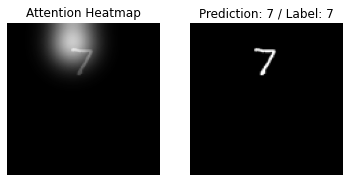

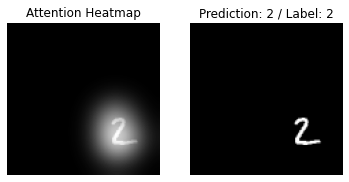

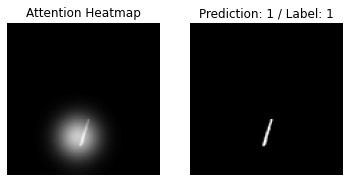

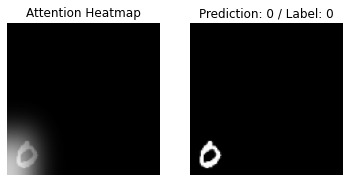

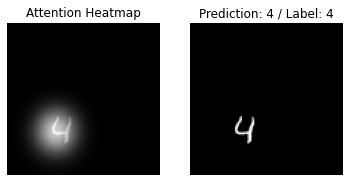

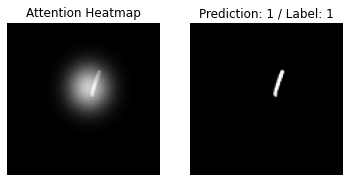

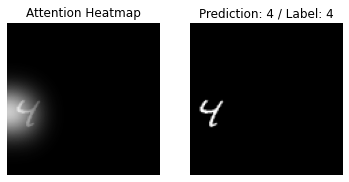

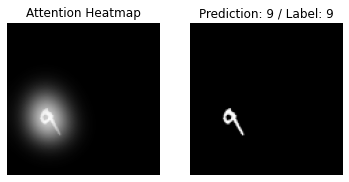

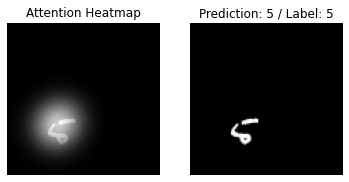

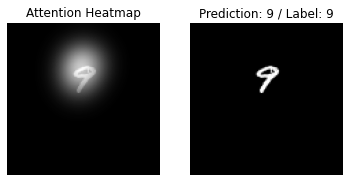

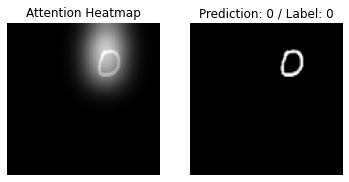

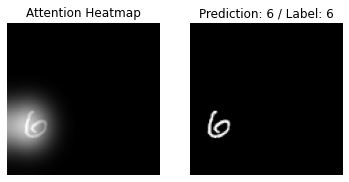

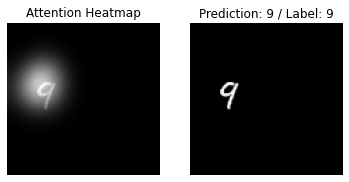

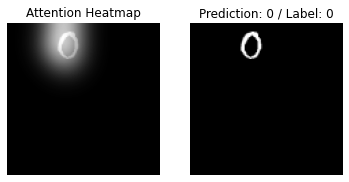

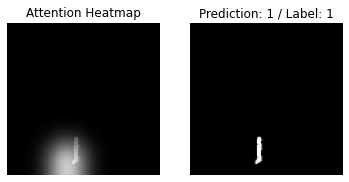

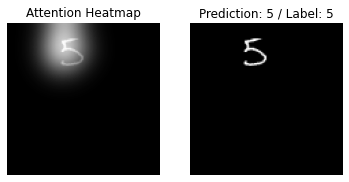

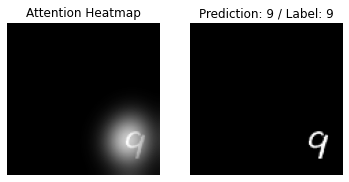

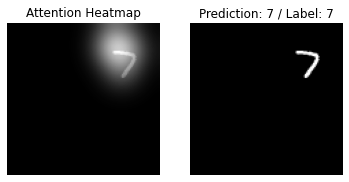

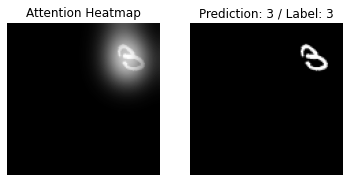

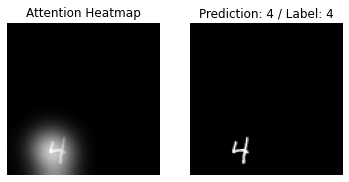

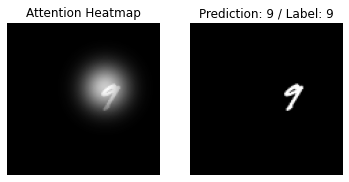

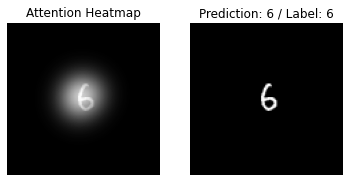

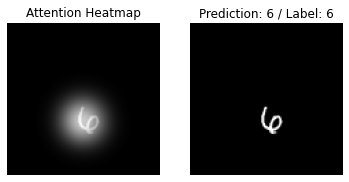

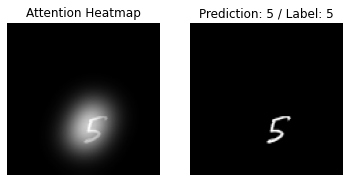

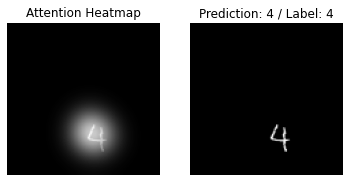

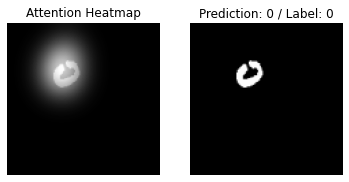

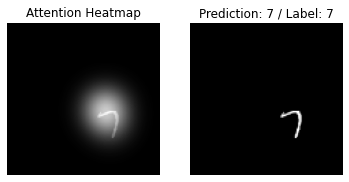

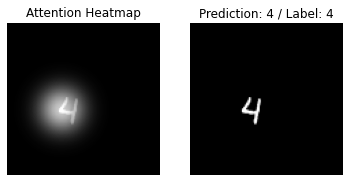

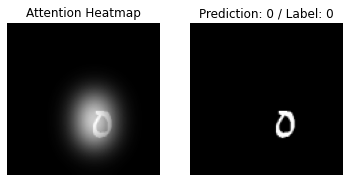

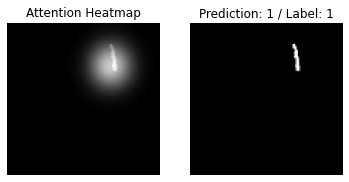

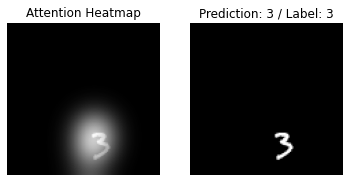

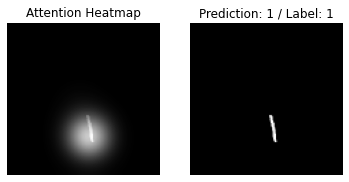

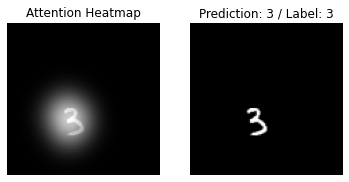

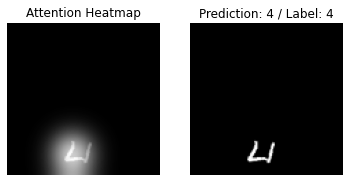

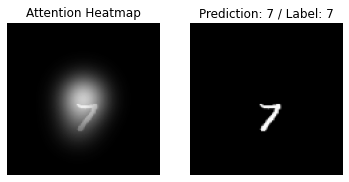

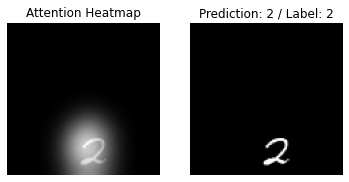

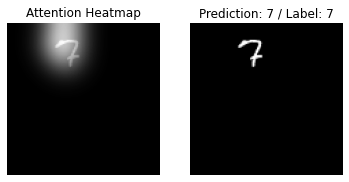

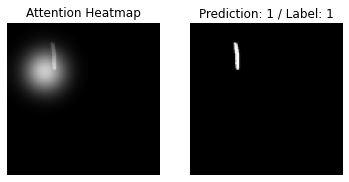

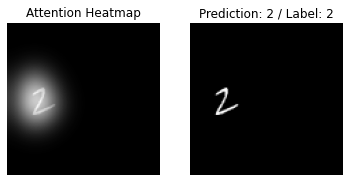

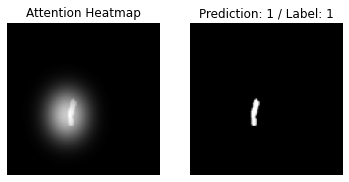

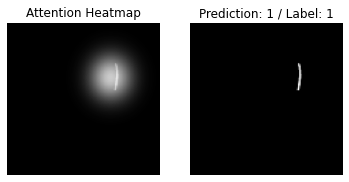

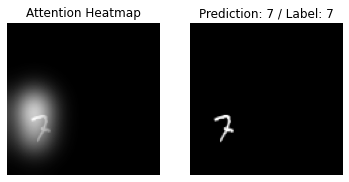

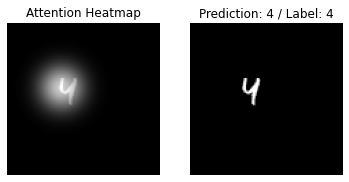

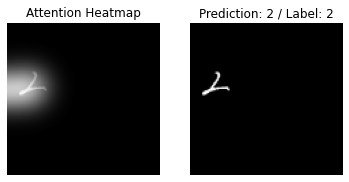

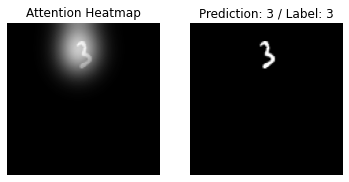

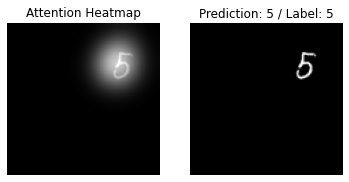

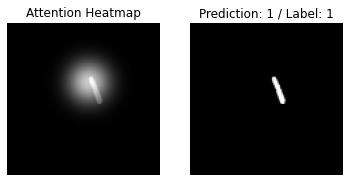

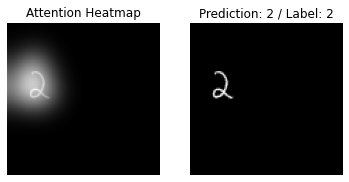

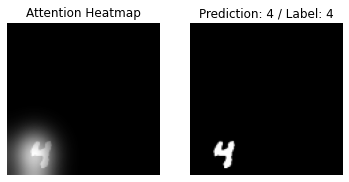

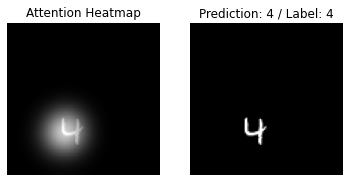

Sample Accuracy: 1.0


In [15]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))